# Predicting most Efficient Interventions for Life Span Increase
#### Data Literacy at University of Tübingen, Winter 2023/24

---
&copy; Daniel Flat, Jackson Harmon, Eric Nazarenus, Aline Bittler 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

Template by Philipp Hennig, 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
from scipy.integrate import quad

from dataclasses import dataclass

In [47]:
# Constants for columns
DEATH_COLUMN = 'dead'
RUNNING_MORALITY_PERCENTAGE_COLUMN = 'cumulative deaths %'
PROBABILITY_OF_DEATH_PER_PERIOD_COLUMN = 'p(death per time period)'
AGE_IN_DAYS_COLUMN = 'age(days)'

# Constants for column values
CONTROL_GROUP_KEY = 'Control'

# Constant parameters
time_period_in_days = 30

In [48]:
df = pd.read_csv(
    "Lifespans_ITP1.csv",
    skiprows=0,
    sep=";",
    index_col=[0, 1],
    skipfooter=0,
    engine="python",
    decimal=",",
)
df

site sex       id     group Rx(ppm) age_initiation(mo)  \
population cohort                                                          
UM-HET3    C2004   TJL   m  JL00005  4-OH-PBN     315                4.0   
           C2004   TJL   m  JL00006  4-OH-PBN     315                4.0   
           C2004   TJL   m  JL00007  4-OH-PBN     315                4.0   
           C2004   TJL   f  JL00095  4-OH-PBN     315                4.0   
           C2004   TJL   f  JL00096  4-OH-PBN     315                4.0   
...                ...  ..      ...       ...     ...                ...   
           C2017    UT   m  UT10744       Syr     300                5.0   
           C2017    UT   m  UT10745       Syr     300                5.0   
           C2017    UT   m  UT10783       Syr     300                5.0   
           C2017    UT   m  UT10784       Syr     300                5.0   
           C2017    UT   m  UT10785       Syr     300                5.0   

                  status  dead  age(days)  
population cohort                          
UM-HET3    C2004    dead     1        896  
           C2004    dead     1       1077  
           C2004    dead     1        790  
           C2004    dead     1        823  
           C2004    dead     1        601  
...                  ...   ...        ...  
           C2017    dead     1        289  
           C2017    dead     1        662  
           C2017    dead     1        440  
           C2017    dead     1        342  
           C2017    dead     1        754  

[27574 rows x 9 columns]

In [49]:
control_group = df.loc[df['group'] == CONTROL_GROUP_KEY]
control_group = control_group.sort_values(by=[AGE_IN_DAYS_COLUMN])
control_group

site sex       id    group Rx(ppm) age_initiation(mo)  \
population cohort                                                         
UM-HET3    C2005    UT   f  UT01531  Control       0                NaN   
           C2004    UT   m  UT00803  Control       0                NaN   
           C2005    UT   f  UT01532  Control       0                NaN   
           C2005    UT   f  UT01529  Control       0                NaN   
           C2005    UT   f  UT01530  Control       0                NaN   
...                ...  ..      ...      ...     ...                ...   
           C2007   TJL   f  JL03117  Control     0.0                NaN   
           C2014   TJL   f  JL11157  Control     0.0                NaN   
           C2007    UM   f  UM23597  Control     0.0                NaN   
           C2015   TJL   f  JL12242  Control       0                NaN   
           C2011    UM   f  UM38745  Control       0                NaN   

                    status  dead  age(days)  
population cohort                            
UM-HET3    C2005   removed     0         27  
           C2004      dead     1         27  
           C2005   removed     0         27  
           C2005   removed     0         29  
           C2005   removed     0         29  
...                    ...   ...        ...  
           C2007      dead     1       1340  
           C2014      dead     1       1358  
           C2007      dead     1       1359  
           C2015      dead     1       1396  
           C2011      dead     1       1456  

[7815 rows x 9 columns]

In [50]:
def group_same_ages(data) -> pd.DataFrame:
    return data.groupby(AGE_IN_DAYS_COLUMN).sum()

def group_ages(data: pd.DataFrame, time_period_in_days: int) -> pd.DataFrame:
    data = data[[DEATH_COLUMN, AGE_IN_DAYS_COLUMN]]

    data = group_same_ages(data)
    
    group_days_by_time_period = lambda x: (x // time_period_in_days)
    groupped_data_by_time_period = data.groupby(group_days_by_time_period).sum()

    index_name = f'age({time_period_in_days} days)'
    groupped_data_by_time_period.index.name = index_name
    return groupped_data_by_time_period

def calculate_running_alive_counts(data: pd.DataFrame) -> pd.DataFrame:
    total = calculate_total(data)
    running_alive = total - data.cumsum()

    # Start dataset with all alive and drop the last column to maintain same
    # shape as before
    running_alive.index += 1
    running_alive = pd.concat([pd.DataFrame([total]), running_alive])[:-1]

    return running_alive

def calculate_total(data: pd.DataFrame) -> pd.DataFrame:
    return data.sum()

def compute_chance_of_death_per_time_period(dead_counts: pd.DataFrame,
                                            running_alive_counts: pd.DataFrame) -> pd.DataFrame:
    return dead_counts / (running_alive_counts + 1e-9)

dead_counts = group_ages(control_group, time_period_in_days)
running_alive_counts = calculate_running_alive_counts(dead_counts)
chance_of_death_per_time_period = compute_chance_of_death_per_time_period(dead_counts, running_alive_counts)

chance_of_death_per_time_period

,dead
0,0.000136
1,0.000407
2,0.000272
3,0.000000
4,0.000951
5,0.001224
6,0.001770
7,0.002455
8,0.004923
9,0.007558


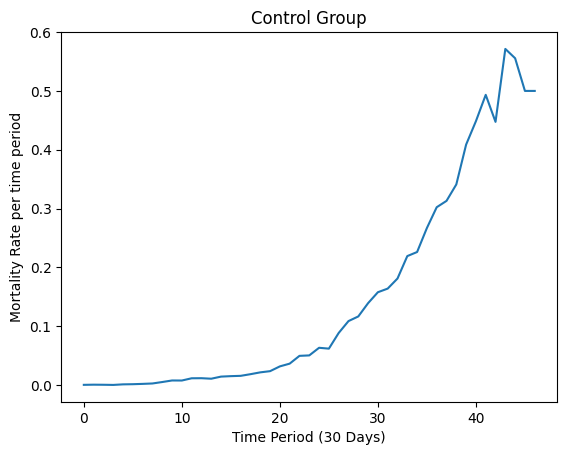

In [51]:
def graph_chance_of_death_per_time_period(chance_of_death_per_time_period: pd.DataFrame,
                                          time_period_in_days: int,
                                          title: str) -> None: 
    plt.plot(chance_of_death_per_time_period)
    plt.xlabel(f'Time Period ({time_period_in_days} Days)')
    plt.ylabel(f'Mortality Rate per time period')
    plt.title(title)
    plt.show()

graph_chance_of_death_per_time_period(chance_of_death_per_time_period, time_period_in_days, 'Control Group')

In [52]:
def calculate_cumulative_deaths(data):
    return data[DEATH_COLUMN].cumsum()

def compute_total_deaths(cumulative_deaths):
    return cumulative_deaths.iloc[-1]

def compute_running_mortality_percentage(data):
    cumulative_deaths = calculate_cumulative_deaths(data)
    total_deaths = compute_total_deaths(cumulative_deaths)
    
    if total_deaths == 0:
        raise ValueError('Invalid dataset (# of deaths must be > 0)')

    return cumulative_deaths / total_deaths

running_mortality_percentage = compute_running_mortality_percentage(control_group)
control_group.loc[:, RUNNING_MORALITY_PERCENTAGE_COLUMN] = running_mortality_percentage
control_group[[AGE_IN_DAYS_COLUMN, RUNNING_MORALITY_PERCENTAGE_COLUMN]]

age(days)  cumulative deaths %
population cohort                                
UM-HET3    C2005          27             0.000000
           C2004          27             0.000136
           C2005          27             0.000136
           C2005          29             0.000136
           C2005          29             0.000136
...                      ...                  ...
           C2007        1340             0.999457
           C2014        1358             0.999593
           C2007        1359             0.999728
           C2015        1396             0.999864
           C2011        1456             1.000000

[7815 rows x 2 columns]

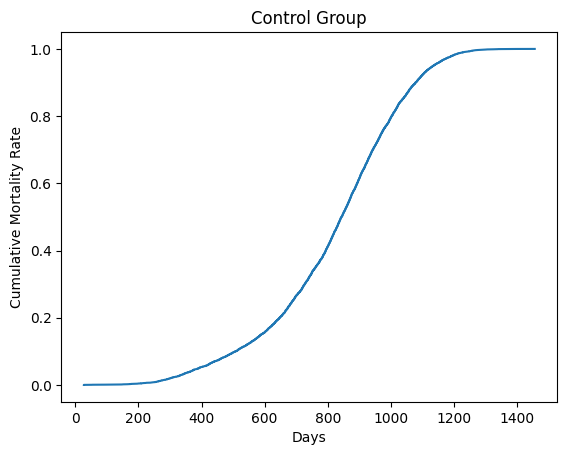

In [53]:
def graph_running_mortality_percentage(age_in_days: pd.DataFrame,
                                       running_mortality_percentage: pd.DataFrame,
                                       title: str) -> None: 
    plt.plot(age_in_days, running_mortality_percentage)
    plt.xlabel('Days')
    plt.ylabel('Cumulative Mortality Rate')
    plt.title(title)
    plt.show()

age_in_days = control_group.loc[:, AGE_IN_DAYS_COLUMN]
running_mortality_rate = control_group.loc[:, RUNNING_MORALITY_PERCENTAGE_COLUMN]

graph_running_mortality_percentage(age_in_days, running_mortality_rate, title='Control Group')

In [54]:
def population_at_daystart(data: pd.DataFrame) -> pd.DataFrame:
    total_population = calculate_total(data)
    population_at_start_of_day = (total_population) - data.cumsum()
    population_at_start_of_day = population_at_start_of_day.shift(1)
    population_at_start_of_day.loc[population_at_start_of_day.index.values[0]] = total_population
    return population_at_start_of_day.rename(columns={"dead": "Population"})

def calculate_mortality_rates(dead_counts: pd.DataFrame, population_data: pd.DataFrame) -> pd.DataFrame:
    return dead_counts['dead'] / population_data['Population']

def remove_days_without_deaths(data: pd.DataFrame) -> pd.DataFrame:
    return data[(data[["dead"]] != 0).all(axis=1)]

def graph_log_mortality_rate(experiment_group: pd.DataFrame):
    dead_counts = remove_days_without_deaths(group_ages(experiment_group, time_period_in_days))
    population_data = population_at_daystart(dead_counts)
    mortality_rate = calculate_mortality_rates(dead_counts, population_data)
    mortality_rate.apply(lambda x: np.log(x)).plot(style='.')
    plt.xlabel("Age")
    plt.ylabel("Mortality Rate")
    plt.title("Log Mortality Rate") 
    
# def gompertz(x, alpha, beta):
#     return alpha * np.exp(beta * x)

def gompertz(x, alpha, beta):
    return alpha * np.exp(beta * x)


def gompertz_cdf(x, alpha, beta):
    return 1 - np.exp(-alpha * (np.exp(beta * x) - 1))

@dataclass
class GompertzParameters:
    alpha: np.float64
    beta: np.float64

    @staticmethod
    def from_sequence(seq):
        return GompertzParameters(alpha=seq[0], beta=seq[1])

    def to_tuple(self):
        return (self.alpha, self.beta)

## provisionally
def fit_gompertz_model(initial_parameters: GompertzParameters, ages, mortality_rate):
    p0 = initial_parameters.to_tuple()
    predicted_parameters, covariance = curve_fit(gompertz, ages, mortality_rate, p0=p0)
    return GompertzParameters.from_sequence(predicted_parameters)

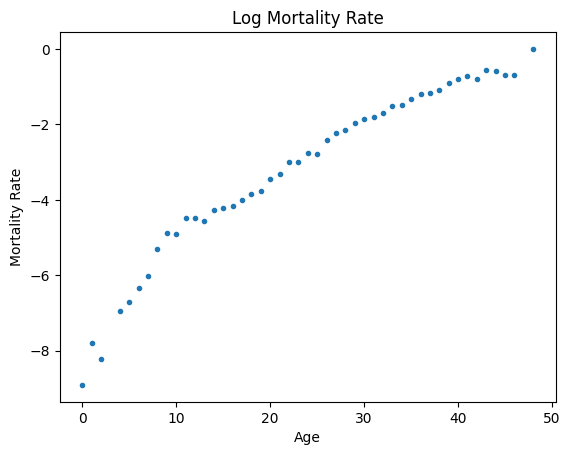

In [55]:
graph_log_mortality_rate(control_group)

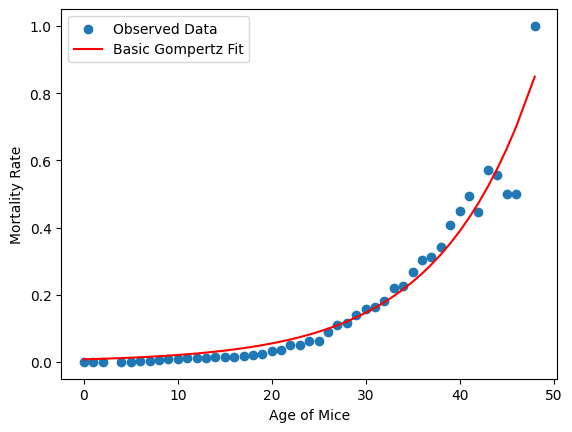

Fitted Parameters:
Alpha: 0.007830696748328179
Beta: 0.007830696748328179


In [56]:
@dataclass
class ExperimentSample:
    ages: pd.DataFrame
    mortality_rate: pd.DataFrame

def compute_experiment_sample(experiment_group: pd.DataFrame, time_period_in_days: int):
    dead_counts = remove_days_without_deaths(group_ages(experiment_group, time_period_in_days))
    population_data = population_at_daystart(dead_counts)

    ages = dead_counts.index
    mortality_rate = calculate_mortality_rates(dead_counts, population_data)

    return ExperimentSample(ages=ages, mortality_rate=mortality_rate)

def fit_gompertz_from_experiment(experiment_sample: ExperimentSample, intitial_parameters: GompertzParameters):
    ages = experiment_sample.ages
    mortality_rate = experiment_sample.mortality_rate
    
    predicted_parameters = fit_gompertz_model(initial_parameters, ages, mortality_rate)
    predicted_mortality = gompertz(ages, predicted_parameters.alpha, predicted_parameters.beta)
    
    return predicted_parameters, predicted_mortality
    
def plot_fitted_gompertz_curve(experiment_sample: ExperimentSample, predicted_mortality: pd.DataFrame):
    ages = experiment_sample.ages
    mortality_rate = experiment_sample.mortality_rate

    # Plot the results
    plt.scatter(ages, mortality_rate, label='Observed Data')
    plt.plot(ages, predicted_mortality, label='Basic Gompertz Fit', color='red')
    plt.xlabel('Age of Mice')
    plt.ylabel('Mortality Rate')
    plt.legend()
    plt.show()


initial_parameters = GompertzParameters(alpha=0.1, beta=0.085)

experiment_sample = compute_experiment_sample(control_group, time_period_in_days)
parameters, predicted_mortality = fit_gompertz_from_experiment(experiment_sample, initial_parameters)
plot_fitted_gompertz_curve(experiment_sample, predicted_mortality)

print("Fitted Parameters:")
print("Alpha:", parameters.alpha)
print("Beta:", parameters.alpha)

In [59]:
mortality_rate = experiment_sample.mortality_rate
r_squared = r2_score(mortality_rate, predicted_mortality)
mse = mean_squared_error(mortality_rate, predicted_mortality)

print(f'R-squared: {r_squared}')
print(f'Mean Squared Error: {mse}')


R-squared: 0.9518350796031604
Mean Squared Error: 0.002267645890377536


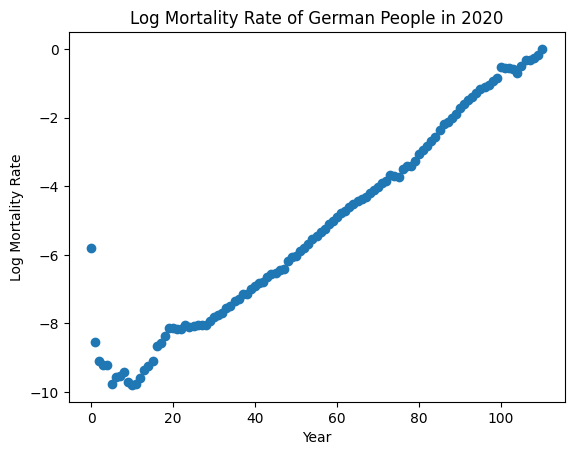

In [60]:
## Import  Human Data
human_mortality_df = pd.read_excel("./Lifespans_Humans.xlsx")
human_mortality_df

human_mortality_df['MortalityRate'] = human_mortality_df['Total'] / human_mortality_df['Population']
human_mortality_df['LogMortalityRate'] = human_mortality_df['MortalityRate'].apply(lambda x: np.log(x))

plt.scatter(human_mortality_df['Age'], human_mortality_df['LogMortalityRate'])
plt.xlabel('Year')
plt.ylabel('Log Mortality Rate')
plt.title('Log Mortality Rate of German People in 2020')
plt.show()

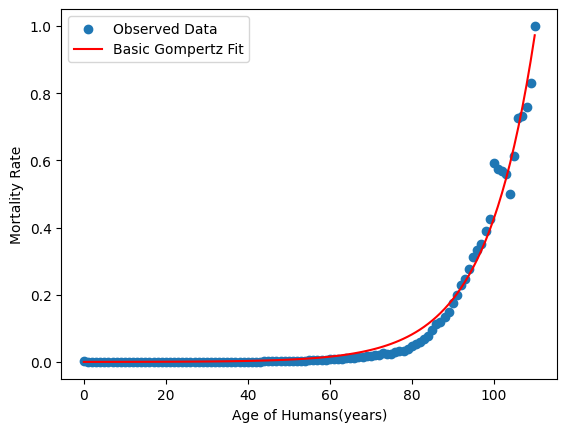

Fitted Parameters:
Alpha: 0.00011028263895295604
Beta: 0.08258451295469804


In [70]:
# Fit Human Data to Gompertz
ages = human_mortality_df['Age']
mortality_rates = human_mortality_df['MortalityRate']
human_samples = ExperimentSample(ages=ages, mortality_rate=mortality_rates)

human_initial_gompertz_parameters = GompertzParameters(alpha=0.1, beta=0.085)
predicted_parameters, predicted_mortality = fit_gompertz_from_experiment(human_samples, human_initial_gompertz_parameters)

predicted_mortality = gompertz(ages, predicted_parameters.alpha, predicted_parameters.beta)

# Plot the results
plt.scatter(ages, mortality_rates, label='Observed Data')
plt.plot(ages, predicted_mortality, label='Basic Gompertz Fit', color='red')
plt.xlabel('Age of Humans(years)')
plt.ylabel('Mortality Rate')
plt.legend()
plt.show()

print("Fitted Parameters:")
print("Alpha:", predicted_parameters.alpha)
print("Beta:", predicted_parameters.beta)


In [71]:
r_squared = r2_score(mortality_rates, predicted_mortality)
mse = mean_squared_error(mortality_rates, predicted_mortality)

print(f'R-squared: {r_squared}')
print(f'Mean Squared Error: {mse}')


R-squared: 0.982527129380706
Mean Squared Error: 0.0007951298970120608


In [86]:
@dataclass
class BootstrapSetup:
    dataset: pd.DataFrame
    time_period_in_days: int
    initial_parameters: GompertzParameters
    n_samples: int

def create_bootstrap_sample(df: pd.DataFrame, n_samples: int) -> pd.DataFrame:
    indices = np.random.randint(low=0, high=len(df), size=n_samples)
    return df.iloc[indices]

def bootstrap_gompertz_parameters_once(setup: BootstrapSetup) -> GompertzParameters:
    bootstrap_sample = create_bootstrap_sample(setup.dataset, setup.n_samples)
    bootstrap_experiment_sample = compute_experiment_sample(bootstrap_sample, setup.time_period_in_days)
    parameters, _ = fit_gompertz_from_experiment(bootstrap_experiment_sample, setup.initial_parameters)
    return parameters

def bootstrap_gompertz_parameters(setup: BootstrapSetup, n_trials: int):
    parameters_list = []
    for _ in range(n_trials):
        parameters = bootstrap_gompertz_parameters_once(setup)
        parameters_list.append(parameters)
    return parameters_list

def calculate_parameter_statistics(gompertz_parameters: [GompertzParameters]) -> GompertzParameters:
    alphas = np.array([p.alpha for p in gompertz_parameters])
    betas = np.array([p.beta for p in gompertz_parameters])
    
    parameter_mean = GompertzParameters(alpha=alphas.mean(), beta=betas.mean())
    parameter_variance = GompertzParameters(alpha=alphas.var(), beta=betas.var())
    
    return parameter_mean, parameter_variance

initial_parameters = GompertzParameters(alpha=0.1, beta=0.085)

mouse_bootstrap_setup = BootstrapSetup(control_group, time_period_in_days=30, initial_parameters=initial_parameters, n_samples=1_000)
mouse_bootstrapped_parameters = bootstrap_gompertz_parameters(mouse_bootstrap_setup, n_trials=1_000)
mouse_parameter_mean, mouse_parameter_variance = calculate_parameter_statistics(mouse_bootstrapped_parameters)

print(f'Mouse Parameter Statistics:')
print(f'mu = {mouse_parameter_mean}')
print(f's^2 =  {mouse_parameter_variance}')

# TODO: Compute parameters for humans
# human_bootstrap_setup = BootstrapSetup(human_mortality_df, time_period_in_days=30, initial_parameters=initial_parameters, n_samples=1_000)
# human_bootstrapped_parameters = bootstrap_gompertz_parameters(human_setup, n_trials=10)

Mouse Parameter Statistics:
mu = GompertzParameters(alpha=0.002900063551396938, beta=0.13169093676136312)
s^2 =  GompertzParameters(alpha=2.7387440378357544e-06, beta=0.00035364990737773896)
